# Pickups by Day and Year

Compare 2020 and 2022 in terms of the number of candidates who picked up petitions by the number of days before the filing deadline.

In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib._color_data import BASE_COLORS, TABLEAU_COLORS
from matplotlib import rc
import matplotlib.ticker as mtick

from scripts.common import current_time

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [3]:
candidates = pd.read_csv('data/candidates.csv')
candidates['pickup_date'] = pd.to_datetime(candidates['pickup_date'])
candidates['filed_date'] = pd.to_datetime(candidates['filed_date'])
years = sorted(candidates[candidates.pickup_date.notnull()].pickup_date.dt.year.unique())

In [4]:
deadlines = {
    2020: pd.to_datetime('2020-08-05')
    , 2022: pd.to_datetime('2022-08-10')
}

start_date = {
    2020: pd.to_datetime('2020-06-26')
    , 2022: pd.to_datetime('2022-07-20')
}

In [5]:
pickup_by_day = candidates.groupby('pickup_date').size()
filed_by_day = candidates.groupby('filed_date').size()

pickup_by_year = {}
filed_by_year = {}
for y in years:
    pickup_by_year[y] = pd.DataFrame(pickup_by_day[pickup_by_day.index.year == y], columns=['pickups'])
    filed_by_year[y] = pd.DataFrame(filed_by_day[filed_by_day.index.year == y], columns=['filers'])

In [6]:
# Start with 2020 data and calculate sums
comp = pd.DataFrame(index=pd.date_range(start=start_date[2020], end=deadlines[2020]))
comp = pd.merge(comp, pickup_by_year[2020].pickups, how='left', left_index=True, right_index=True)
comp = pd.merge(comp, filed_by_year[2020].filers, how='left', left_index=True, right_index=True)
comp.pickups = comp.pickups.fillna(0)
comp.filers = comp.filers.fillna(0)
comp['cumulative_pickups_2020'] = comp.pickups.cumsum()
comp['cumulative_filers_2020'] = comp.filers.cumsum()
comp['days_to_deadline'] = (comp.index - deadlines[2020]).days
comp.drop(columns=['pickups', 'filers'], inplace=True)

In [7]:
# Join 2022 data and calculate sums
pickup_by_year[2022]['days_to_deadline'] = (pickup_by_year[2022].index - deadlines[2022]).days
filed_by_year[2022]['days_to_deadline'] = (filed_by_year[2022].index - deadlines[2022]).days

comp = pd.merge(comp, pickup_by_year[2022], how='left', on='days_to_deadline')
comp = pd.merge(comp, filed_by_year[2022], how='left', on='days_to_deadline')

comp['cumulative_pickups_2022'] = comp.pickups.cumsum().ffill()
comp['cumulative_filers_2022'] = comp.filers.cumsum().ffill()

# Fill in NULLs where 2022 dates haven't happened yet
comp.loc[
    comp.days_to_deadline.isin(range(pickup_by_year[2022].days_to_deadline.max() + 1, 1))
    , ['cumulative_pickups_2022', 'cumulative_filers_2022']
] = None

comp.drop(columns=['pickups', 'filers'], inplace=True)
# comp.rename(columns={'pickups': 'pickups_2022'}, inplace=True)

In [8]:
# Candidates as a percentage of the SMDs in that election
for c in [c for c in comp.columns if '2020' in c]:
    comp[c + '_perc'] = comp[c] / 296
    
for c in [c for c in comp.columns if '2022' in c]:
    comp[c + '_perc'] = comp[c] / 345

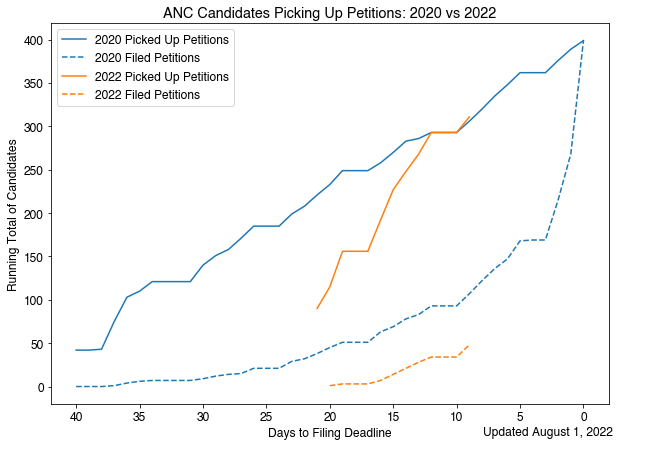

In [9]:
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(10,7))

plt.plot(comp['cumulative_pickups_2020'], label='2020 Picked Up Petitions', color='tab:blue', linestyle='solid')
plt.plot(comp['cumulative_filers_2020'], label='2020 Filed Petitions', color='tab:blue', linestyle='dashed')
plt.plot(comp['cumulative_pickups_2022'], label='2022 Picked Up Petitions', color='tab:orange', linestyle='solid')
plt.plot(comp['cumulative_filers_2022'], label='2022 Filed Petitions', color='tab:orange', linestyle='dashed')

xtick_range = list(range(0,len(comp), 5))
plt.xticks(ticks=xtick_range, labels=abs(comp.loc[xtick_range, 'days_to_deadline']))
plt.xlabel('Days to Filing Deadline')
plt.ylabel('Running Total of Candidates')
plt.legend()
plt.title('ANC Candidates Picking Up Petitions: 2020 vs 2022')

citation = f"Updated {current_time()}"
ax.annotate(
    xy=(0.945, 0.05), text=citation, xycoords='figure fraction'
    , ha='right', va='center'
)

_ = plt.savefig(
    'docs/images/Candidates_Picking_Up_and_Filing.png', transparent=False, facecolor='white', bbox_inches='tight')

In [10]:
# # Percentage graph
# matplotlib.rc('font', family='sans-serif') 
# matplotlib.rc('font', serif='Helvetica Neue') 
# matplotlib.rc('text', usetex='false') 
# matplotlib.rcParams.update({'font.size': 12})

# fig, ax = plt.subplots(figsize=(10,7))

# plt.plot(comp['cumulative_pickups_2020_perc'], label='2020 Picked Up Petitions', color='tab:blue', linestyle='dashed')
# plt.plot(comp['cumulative_filers_2020_perc'], label='2020 Filed Petitions', color='tab:blue', linestyle='solid')
# plt.plot(comp['cumulative_pickups_2022_perc'], label='2022 Picked Up Petitions', color='tab:orange', linestyle='dashed')
# plt.plot(comp['cumulative_filers_2022_perc'], label='2022 Filed Petitions', color='tab:orange', linestyle='solid')

# xtick_range = list(range(0,len(comp), 5))
# plt.xticks(ticks=xtick_range, labels=abs(comp.loc[xtick_range, 'days_to_deadline']))
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
# plt.xlabel('Days to Filing Deadline')
# plt.ylabel('Running Total of Candidates as a Percentage of Districts')
# plt.legend()
# plt.title('ANC Candidates Picking Up Petitions: 2020 vs 2022')

In [11]:
comp

,cumulative_pickups_2020,cumulative_filers_2020,days_to_deadline,cumulative_pickups_2022,cumulative_filers_2022,cumulative_pickups_2020_perc,cumulative_filers_2020_perc,cumulative_pickups_2022_perc,cumulative_filers_2022_perc
0,42.0,0.0,-40,NaN,NaN,0.141892,0.000000,NaN,NaN
1,42.0,0.0,-39,NaN,NaN,0.141892,0.000000,NaN,NaN
2,43.0,0.0,-38,NaN,NaN,0.145270,0.000000,NaN,NaN
3,75.0,1.0,-37,NaN,NaN,0.253378,0.003378,NaN,NaN
4,103.0,4.0,-36,NaN,NaN,0.347973,0.013514,NaN,NaN
5,110.0,6.0,-35,NaN,NaN,0.371622,0.020270,NaN,NaN
6,121.0,7.0,-34,NaN,NaN,0.408784,0.023649,NaN,NaN
7,121.0,7.0,-33,NaN,NaN,0.408784,0.023649,NaN,NaN
8,121.0,7.0,-32,NaN,NaN,0.408784,0.023649,NaN,NaN
9,121.0,7.0,-31,NaN,NaN,0.408784,0.023649,NaN,NaN
